In [30]:
""" The purpose of this script is to perform a loose optimization of the cortical thickness data run through a vae
before performing a more rigorous optimization. This is done to get a rough idea of the best hyperparameters to use for
a cross validation. In this case we use a latent dimensionality of 15.
"""

from utils import generate_data_thickness_only
from models.vae_models import create_vae_decoder, create_vae_encoder, VAE
from modelUtils.vae_utils import create_vae
import matplotlib.pyplot as plt
import os
import pandas as pd

# Testing Beta Values

In [31]:
cur = os.getcwd()
filename = 'megasample_ctvol_500sym_max2percIV_cleaned.csv'
filepath = os.path.join(cur, '../data/cleaned_data/', filename)
train_data, val_data, test_data = generate_data_thickness_only(filepath)
num_features = train_data.element_spec[0].shape[0]
train_data = train_data.batch(128)

val_batch_size = val_data.cardinality().numpy()
val_data = val_data.batch(val_batch_size)

betas = [1e-2, 1e-3, 1e-4, 1e-5]
hist = []
val_results = []

In [32]:
for beta in betas:
    encoder = create_vae_encoder(num_features, [100, 100], 15, 'relu', 'glorot_uniform')
    decoder = create_vae_decoder(15, [100, 100], num_features, 'relu', 'glorot_uniform')
    vae = VAE(encoder, decoder, beta)
    vae.compile()

    history = vae.fit(train_data, epochs=300, validation_data=val_data, verbose=0)
    hist.append(history)
    vr = vae.evaluate(val_data, verbose=0)
    val_results.append(vr)

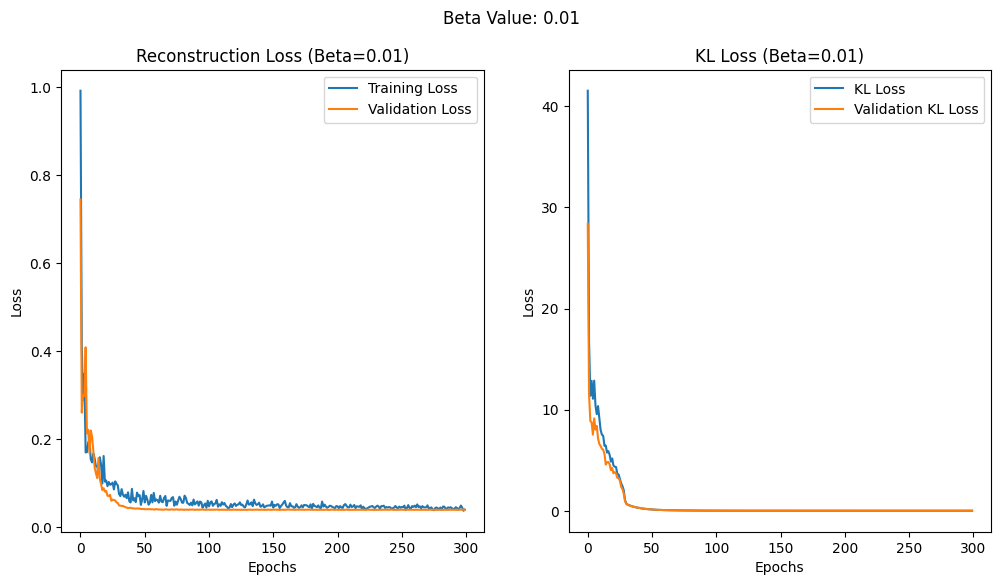

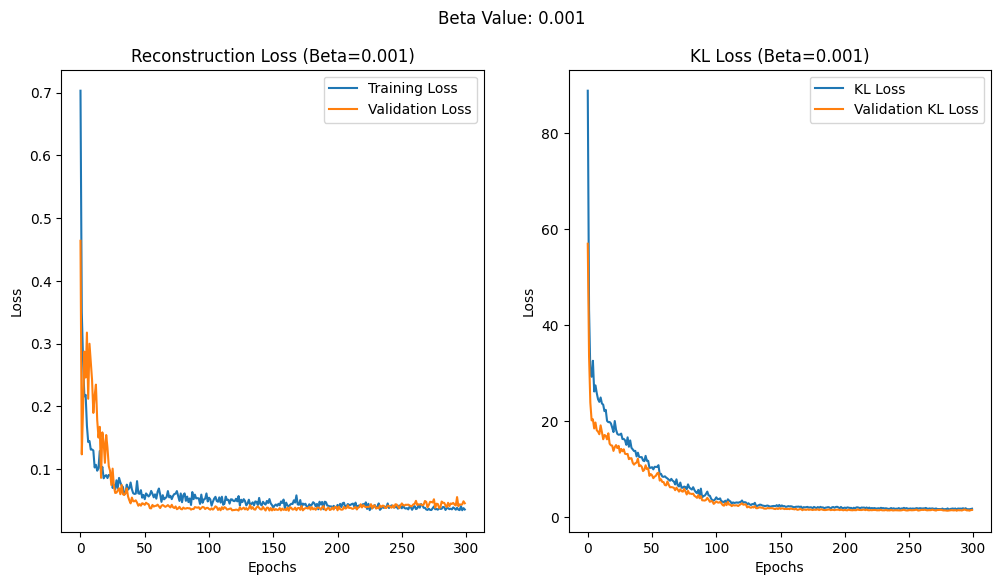

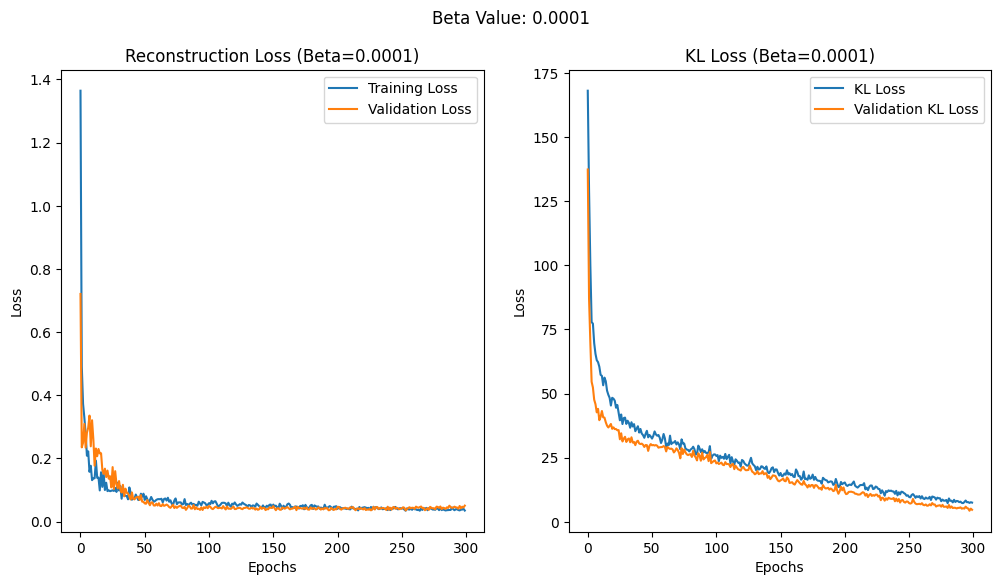

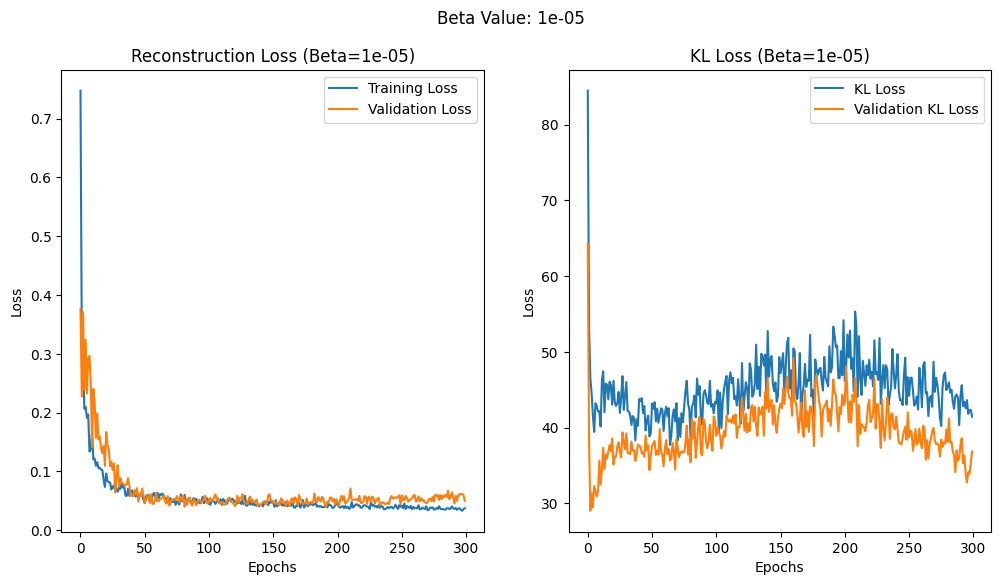

In [33]:
for i, history in enumerate(hist):
    beta = betas[i]

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Reconstruction Loss
    ax1.plot(history.history['reconstruction_loss'], label='Training Loss')
    ax1.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
    ax1.set_title(f'Reconstruction Loss (Beta={beta})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot KL Loss
    ax2.plot(history.history['kl_loss'], label='KL Loss')
    ax2.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    ax2.set_title(f'KL Loss (Beta={beta})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add a common title for the figure
    fig.suptitle(f'Beta Value: {beta}')

    # Display the figure
    plt.show()

In [34]:
result_df = pd.DataFrame(val_results, columns=['kl_loss','r_squared', 'reconstruction_loss', 'total_loss'] ,index=betas)

# Display results
print(result_df[['kl_loss', 'reconstruction_loss', 'total_loss', 'r_squared']])

           kl_loss  reconstruction_loss  total_loss  r_squared
0.01000   0.000069             0.039675    0.039744   0.717898
0.00100   1.431373             0.045803    1.477176   0.674324
0.00010   4.660811             0.050084    4.710895   0.643883
0.00001  36.853680             0.049895   36.903576   0.645229


## Beta Results

From the above plots, we can see that the beta values of 0.00001 and 0.001 lead to a kl loss that is too high, meaning that the latent dimensions are not being regularized properly. It is clear then, that the optimal beta value, at least for the latent dimensionality of 15, should be greater than 0.0001. Looking at the values tested above that, we can see that the validation kl loss is minimized for a beta value of 0.01. However, with this beta value, it seems that the latent dimensions may be over normalized, as the kl loss is very small. This is also evidenced by the results of the beta value of 0.001, where the kl loss is much higher, but both the reconstruction loss and the r squared values are higher.

With these results, we can determine that the optimal beta value for this dataset will likely lie between 0.01 and 0.0001. This remains to be seen for other latent dimensionalites.

# Testing Hidden Dimensionality

In [35]:
beta = 1e-3
hidden_dims = [[50,50],[100,100], [200,200], [300,300], [300, 200], [200, 100], [100, 50], [300, 200, 100], [200, 100, 50], [200, 200, 200], [100, 100, 100], [50, 50, 50]]
hist = []
val_results = []
for h_dim in hidden_dims:
    print(h_dim)
    encoder = create_vae_encoder(num_features, h_dim, 15, 'relu', 'glorot_uniform')
    decoder = create_vae_decoder(15, h_dim, num_features, 'relu', 'glorot_uniform')
    vae = VAE(encoder, decoder, beta=beta)
    vae.compile()

    history = vae.fit(train_data, epochs=300, validation_data=val_data, verbose=0)
    hist.append(history)
    vr = vae.evaluate(val_data, verbose=0)
    val_results.append(vr)

[50, 50]
[100, 100]
[200, 200]
[300, 300]
[300, 200]
[200, 100]
[100, 50]
[300, 200, 100]
[200, 100, 50]
[200, 200, 200]
[100, 100, 100]
[50, 50, 50]


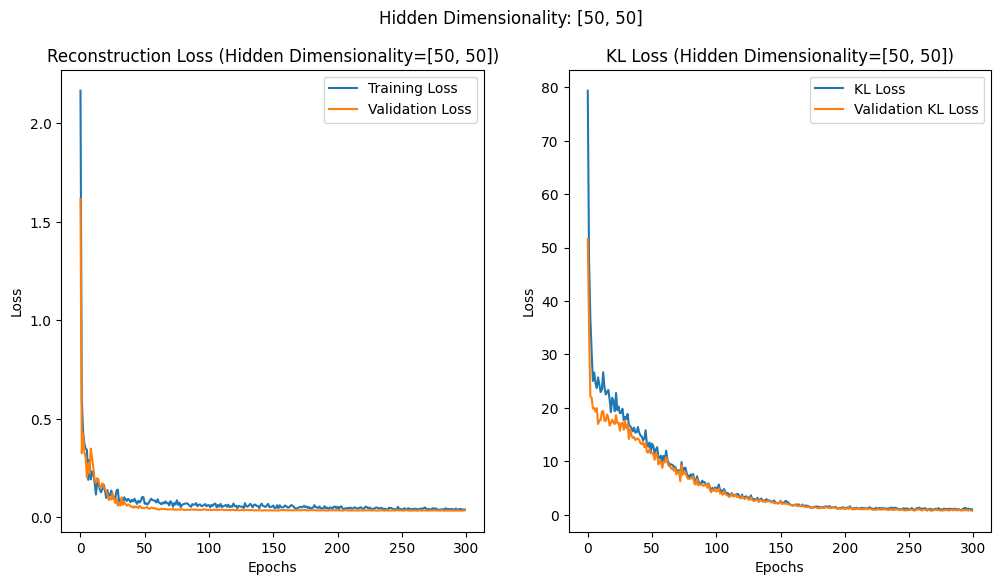

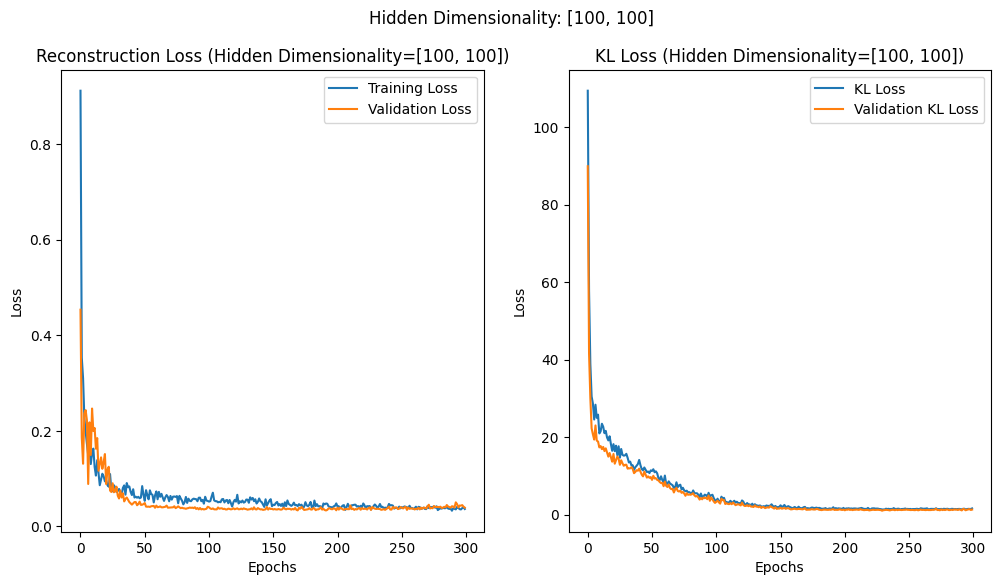

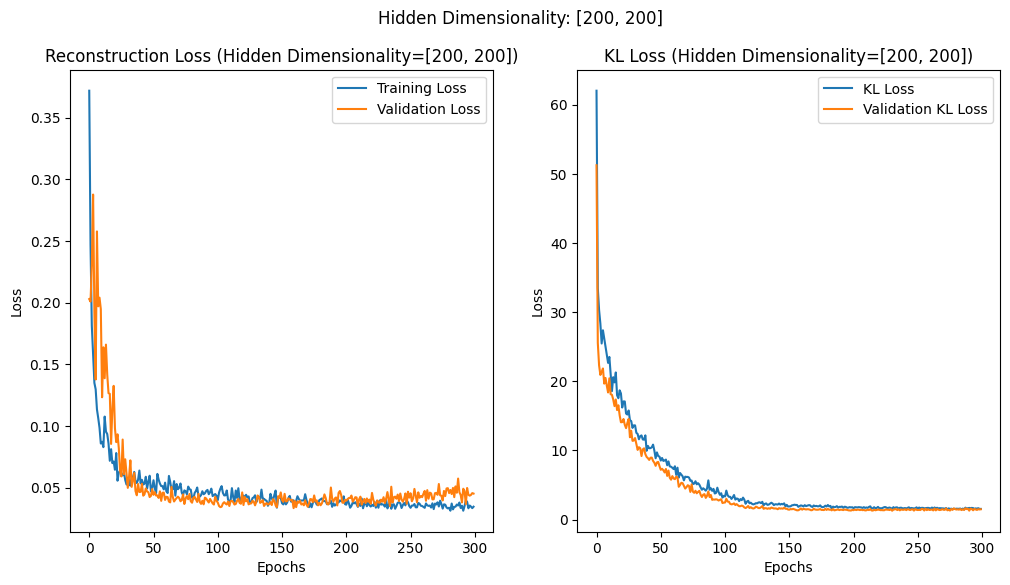

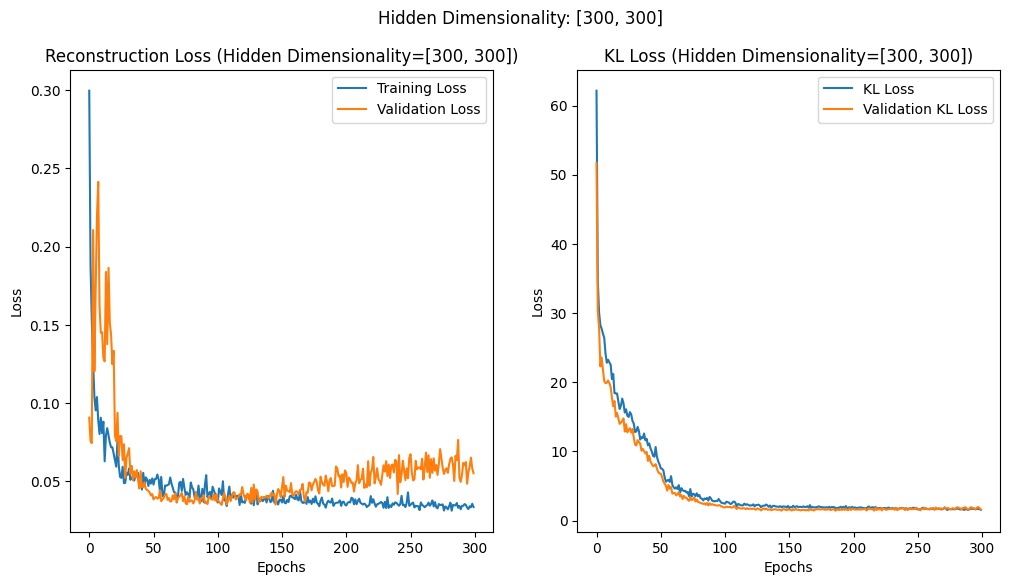

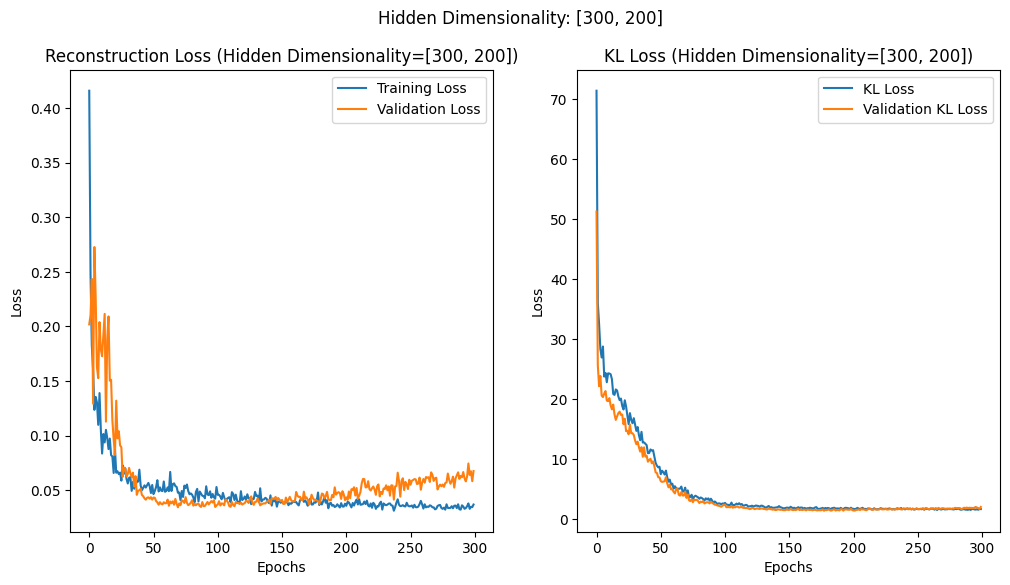

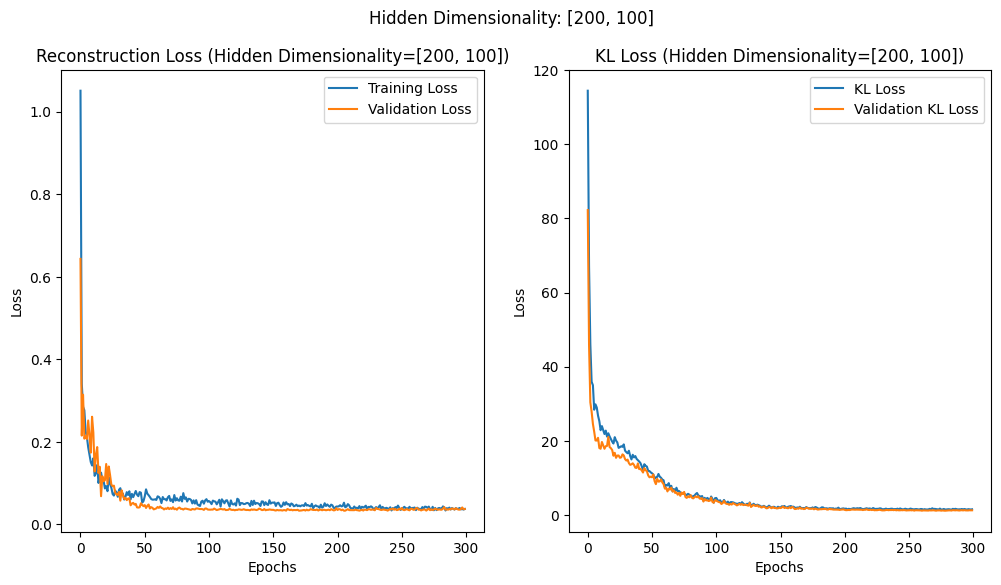

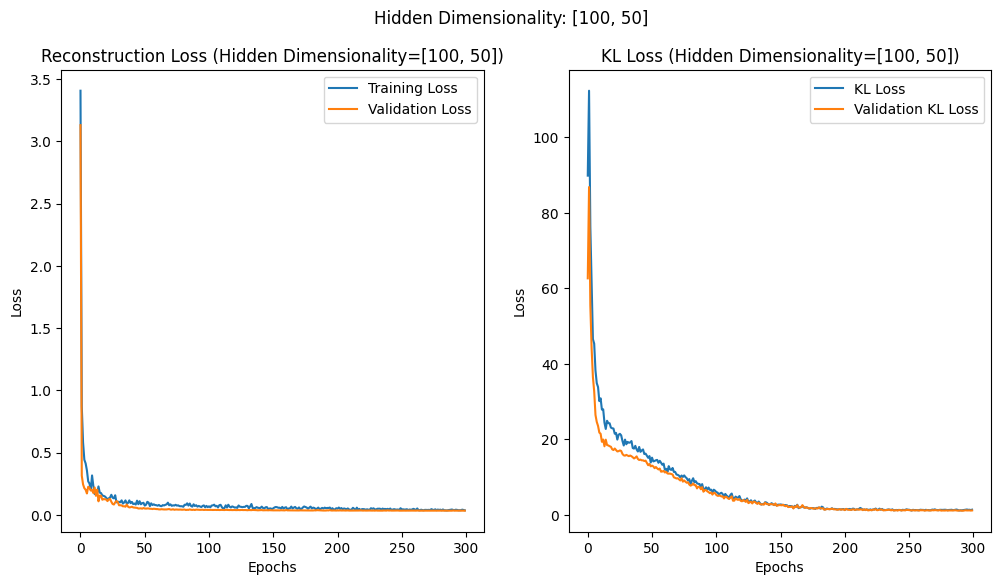

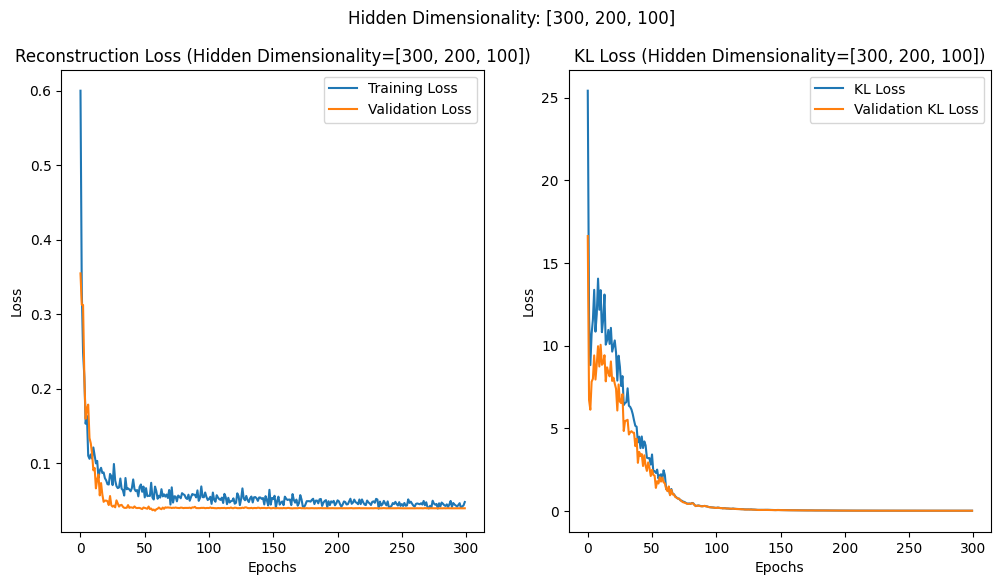

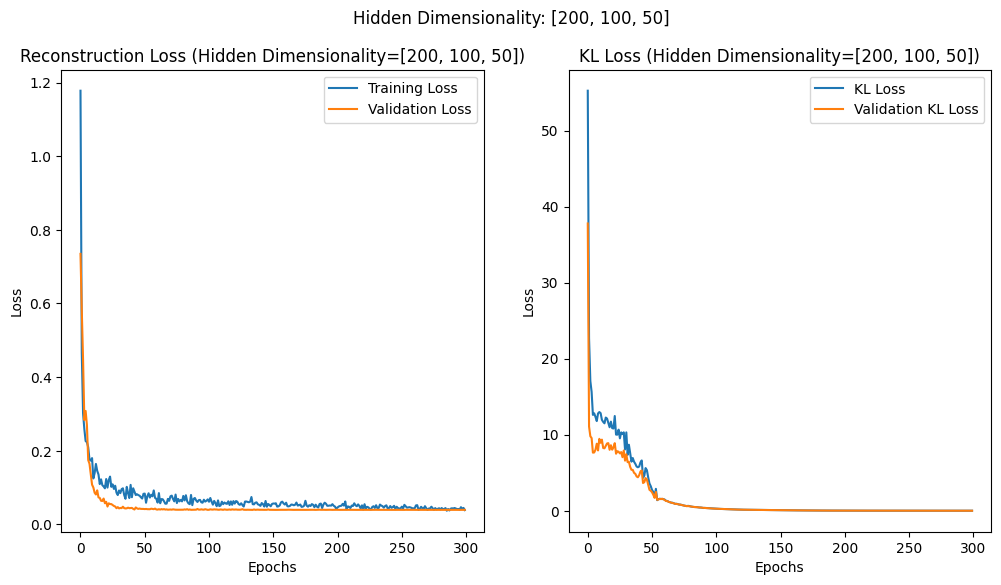

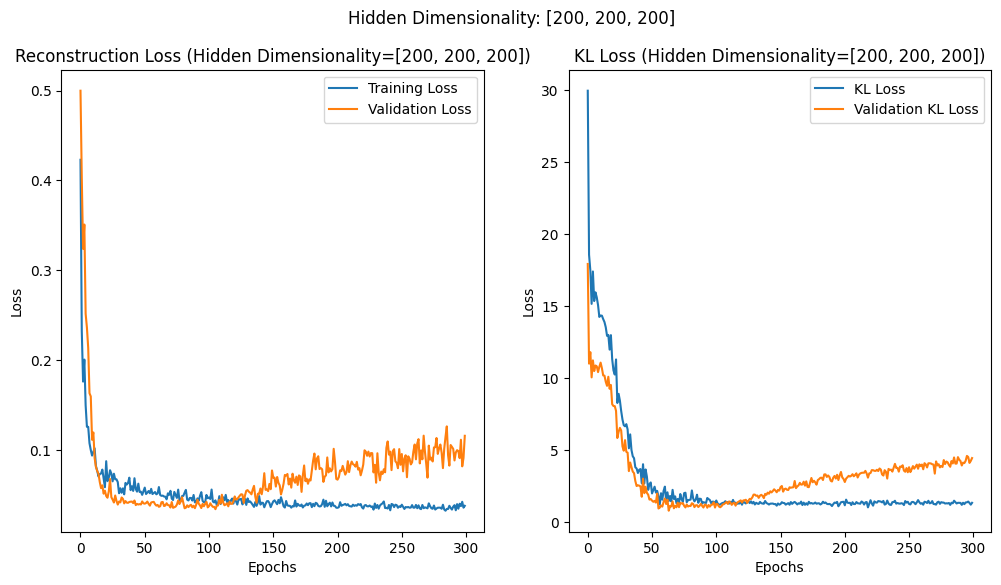

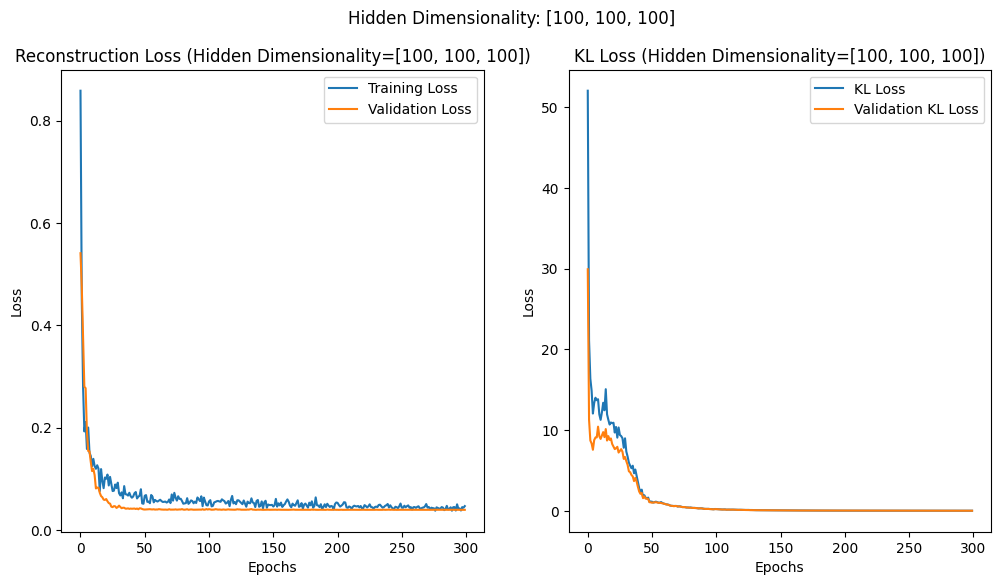

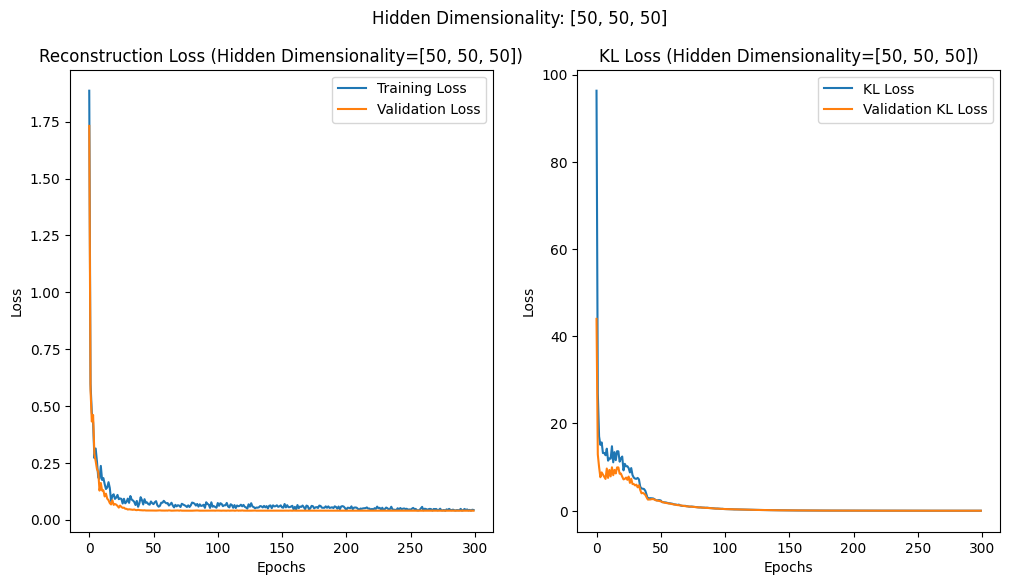

In [36]:
for i, history in enumerate(hist):
    h_dim = hidden_dims[i]

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Reconstruction Loss
    ax1.plot(history.history['reconstruction_loss'], label='Training Loss')
    ax1.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
    ax1.set_title(f'Reconstruction Loss (Hidden Dimensionality={h_dim})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot KL Loss
    ax2.plot(history.history['kl_loss'], label='KL Loss')
    ax2.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    ax2.set_title(f'KL Loss (Hidden Dimensionality={h_dim})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add a common title for the figure
    fig.suptitle(f'Hidden Dimensionality: {h_dim}')

    # Display the figure
    plt.show()


In [37]:
hidden_dims_str = [str(dim) for dim in hidden_dims]
result_df = pd.DataFrame(val_results, columns=['kl_loss','r_squared', 'reconstruction_loss', 'total_loss'] ,index=hidden_dims_str)

# Display results
print(result_df[['kl_loss', 'reconstruction_loss', 'total_loss', 'r_squared']])

                  kl_loss  reconstruction_loss  total_loss  r_squared
[50, 50]         0.758924             0.035888    0.794812   0.744824
[100, 100]       1.291456             0.039276    1.330732   0.720732
[200, 200]       1.488540             0.045764    1.534304   0.674601
[300, 300]       1.592134             0.054963    1.647097   0.609187
[300, 200]       2.008052             0.068123    2.076175   0.515621
[200, 100]       1.286841             0.036754    1.323595   0.738661
[100, 50]        1.143393             0.033099    1.176492   0.764651
[300, 200, 100]  0.000503             0.039564    0.040067   0.718681
[200, 100, 50]   0.000301             0.039410    0.039711   0.719778
[200, 200, 200]  4.463800             0.115651    4.579451   0.177678
[100, 100, 100]  0.000300             0.039447    0.039747   0.719517
[50, 50, 50]     0.000437             0.039452    0.039888   0.719483


In [39]:
beta = 1e-3
hidden_dims = [[50, 50], [100, 50], [40,40], [60, 60], [30, 30], [50, 25], [75, 50], [100, 75]]
hist = []
val_results = []
for h_dim in hidden_dims:
    print(h_dim)
    encoder = create_vae_encoder(num_features, h_dim, 15, 'relu', 'glorot_uniform')
    decoder = create_vae_decoder(15, h_dim, num_features, 'relu', 'glorot_uniform')
    vae = VAE(encoder, decoder, beta=beta)
    vae.compile()

    history = vae.fit(train_data, epochs=300, validation_data=val_data, verbose=0)
    hist.append(history)
    vr = vae.evaluate(val_data, verbose=0)
    val_results.append(vr)

[50, 50]
[100, 50]
[40, 40]
[60, 60]
[30, 30]
[50, 25]
[75, 50]
[100, 75]


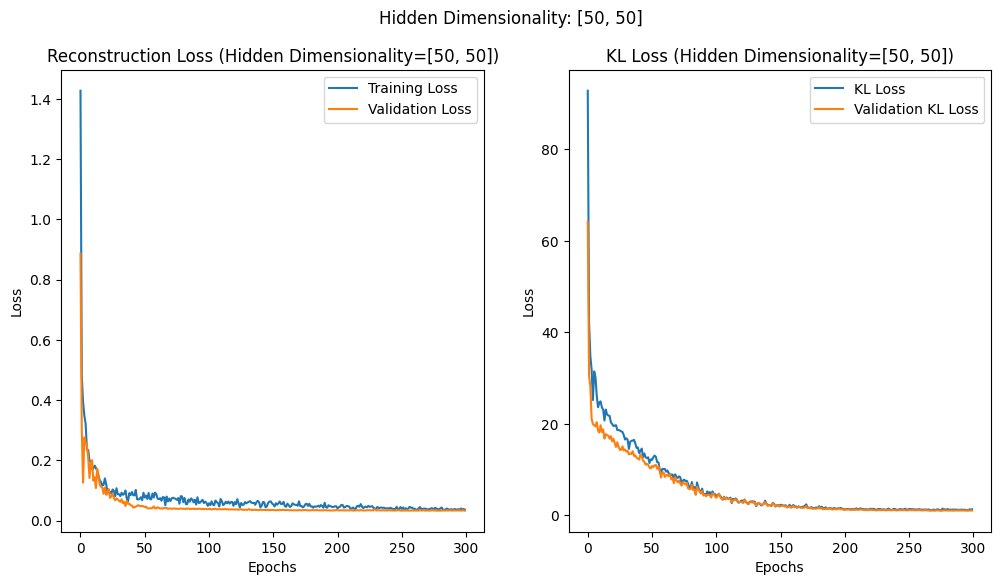

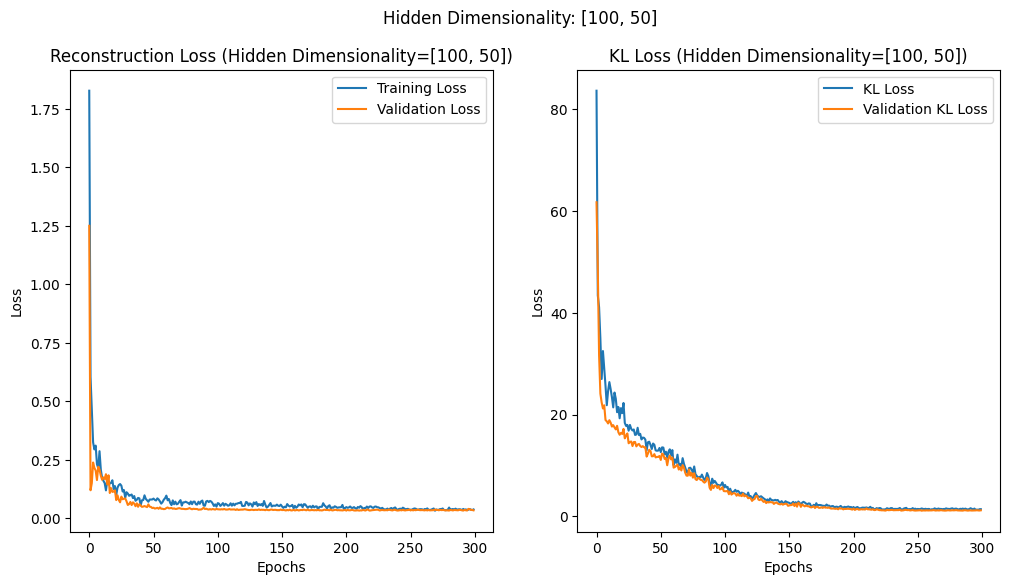

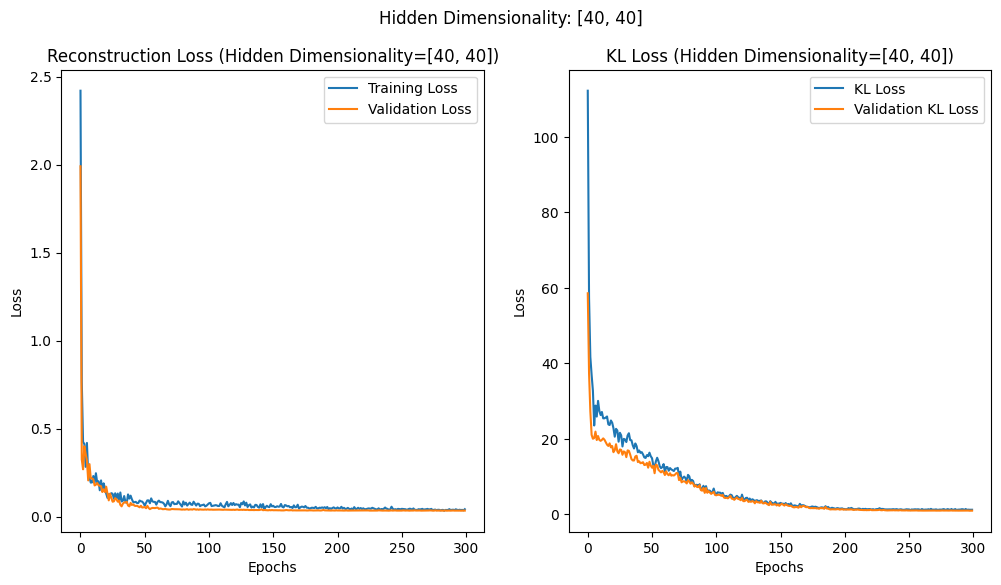

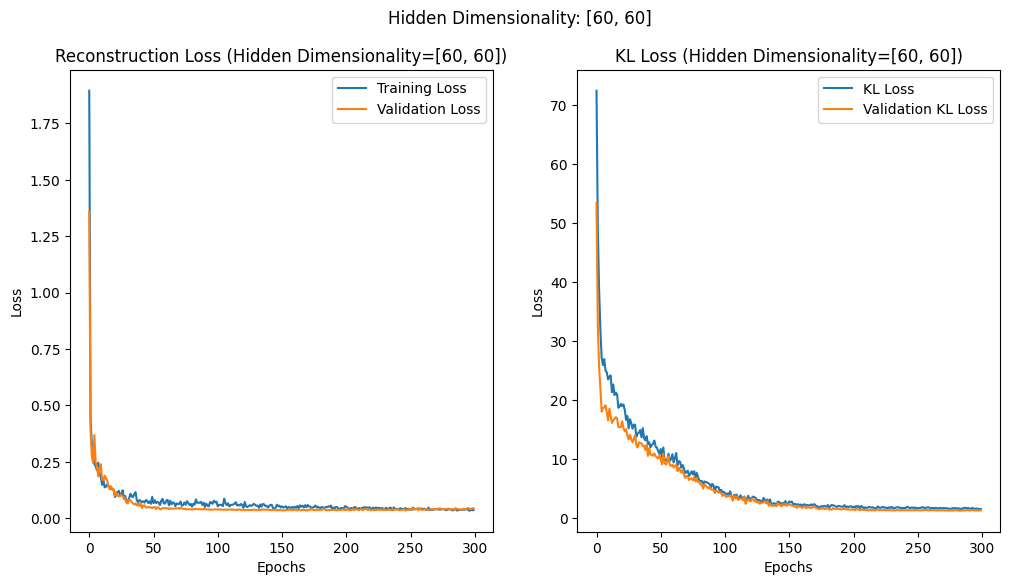

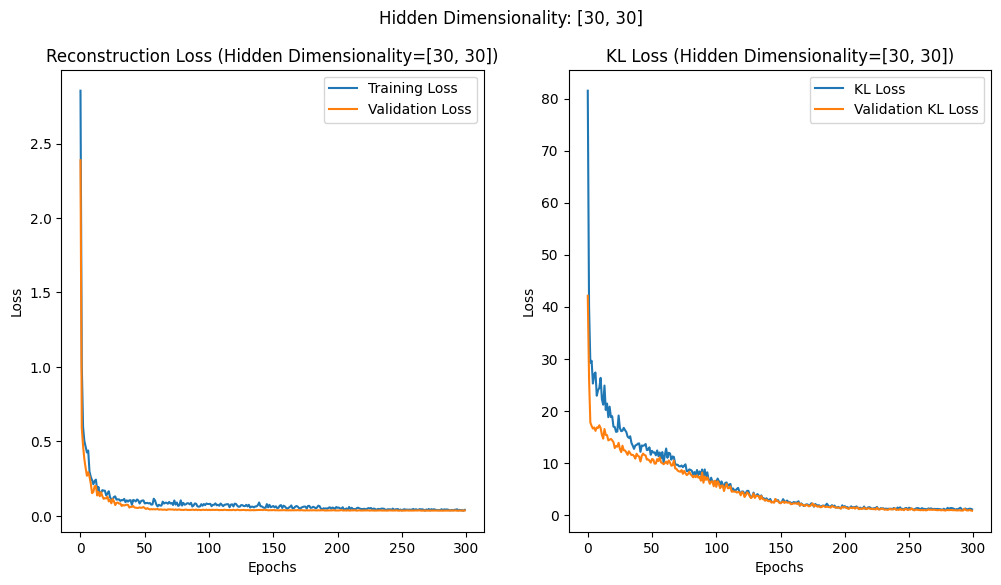

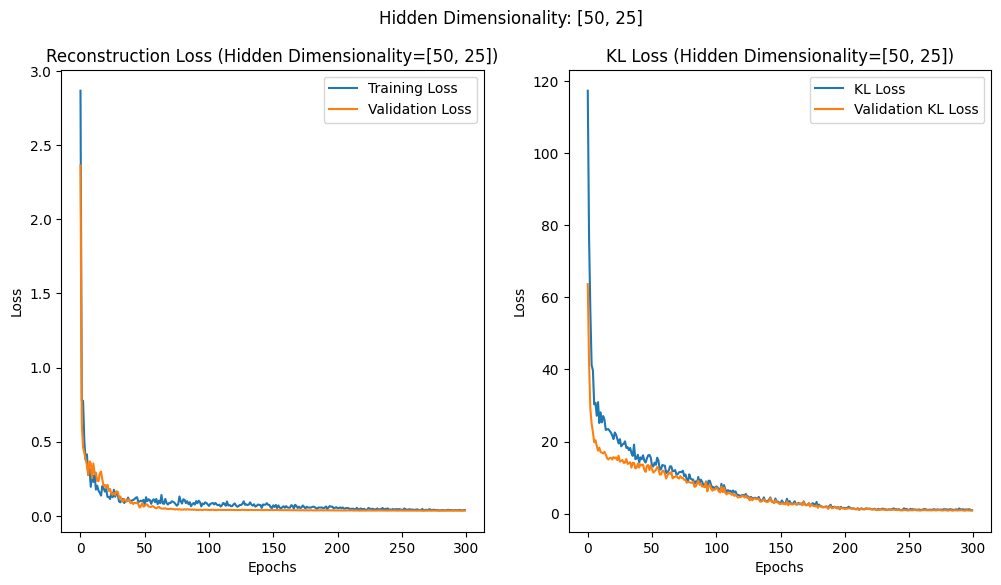

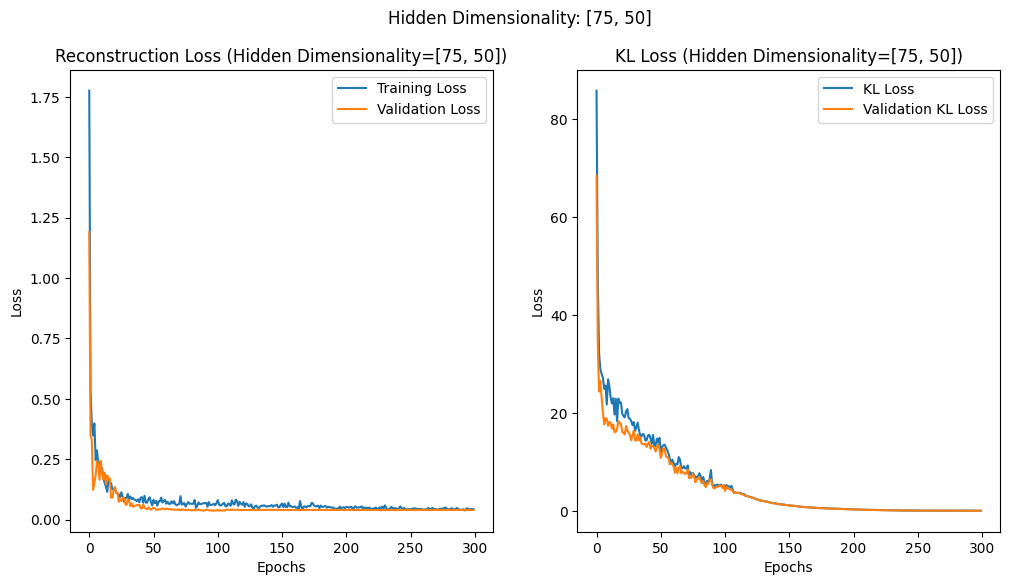

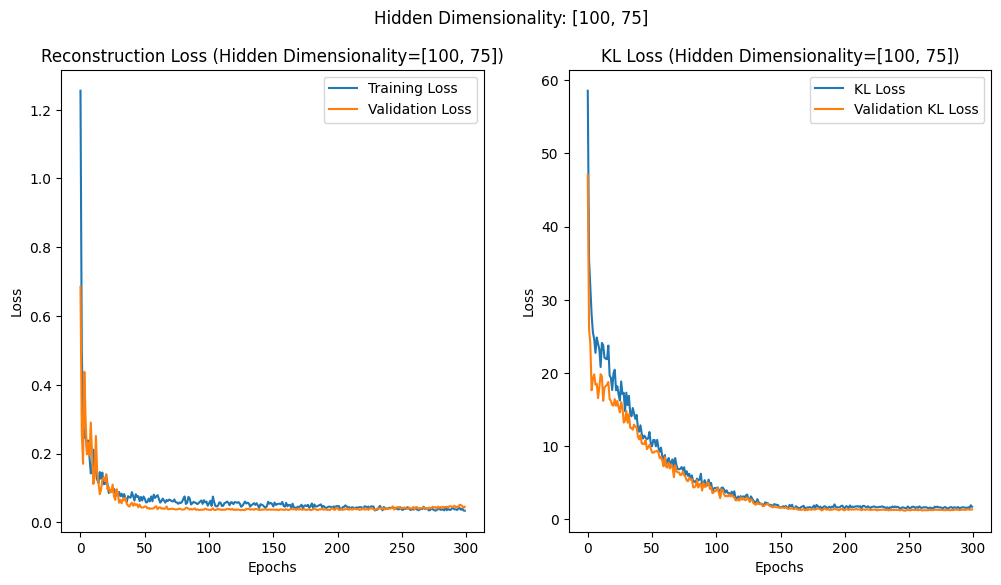

In [40]:
for i, history in enumerate(hist):
    h_dim = hidden_dims[i]

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Reconstruction Loss
    ax1.plot(history.history['reconstruction_loss'], label='Training Loss')
    ax1.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
    ax1.set_title(f'Reconstruction Loss (Hidden Dimensionality={h_dim})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot KL Loss
    ax2.plot(history.history['kl_loss'], label='KL Loss')
    ax2.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    ax2.set_title(f'KL Loss (Hidden Dimensionality={h_dim})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add a common title for the figure
    fig.suptitle(f'Hidden Dimensionality: {h_dim}')

    # Display the figure
    plt.show()

In [41]:
hidden_dims_str = [str(dim) for dim in hidden_dims]
result_df = pd.DataFrame(val_results, columns=['kl_loss','r_squared', 'reconstruction_loss', 'total_loss'] ,index=hidden_dims_str)

# Display results
print(result_df[['kl_loss', 'reconstruction_loss', 'total_loss', 'r_squared']])

            kl_loss  reconstruction_loss  total_loss  r_squared
[50, 50]   1.034802             0.033274    1.068076   0.763407
[100, 50]  1.195088             0.034829    1.229917   0.752351
[40, 40]   0.985667             0.033973    1.019640   0.758437
[60, 60]   1.316001             0.043654    1.359655   0.689600
[30, 30]   0.796184             0.035956    0.832140   0.744338
[50, 25]   0.868142             0.034763    0.902906   0.752818
[75, 50]   0.002857             0.039549    0.042406   0.718793
[100, 75]  1.350785             0.045002    1.395788   0.680016


In [45]:
latent_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
beta = 1e-3

hist = []
val_results = []
for l_dim in latent_dims:
    print(l_dim)
    encoder = create_vae_encoder(num_features, [50, 50], l_dim, 'relu', 'glorot_uniform')
    decoder = create_vae_decoder(l_dim, [50, 50], num_features, 'relu', 'glorot_uniform')
    vae = VAE(encoder, decoder, beta=beta)
    vae.compile()

    history = vae.fit(train_data, epochs=300, validation_data=val_data, verbose=0)
    hist.append(history)
    vr = vae.evaluate(val_data, verbose=0)
    val_results.append(vr)

2
3
4
5
6
7
8
9
10
15


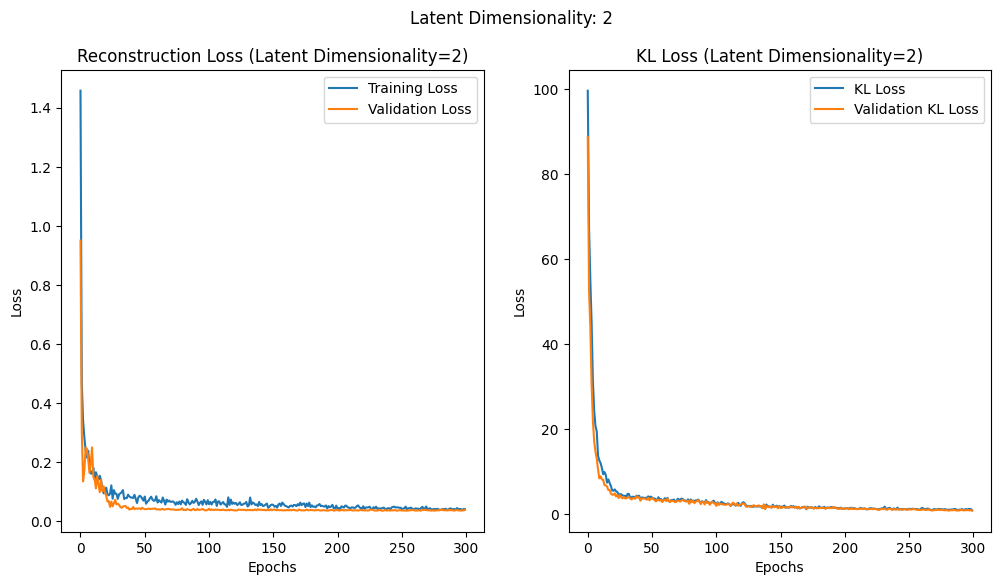

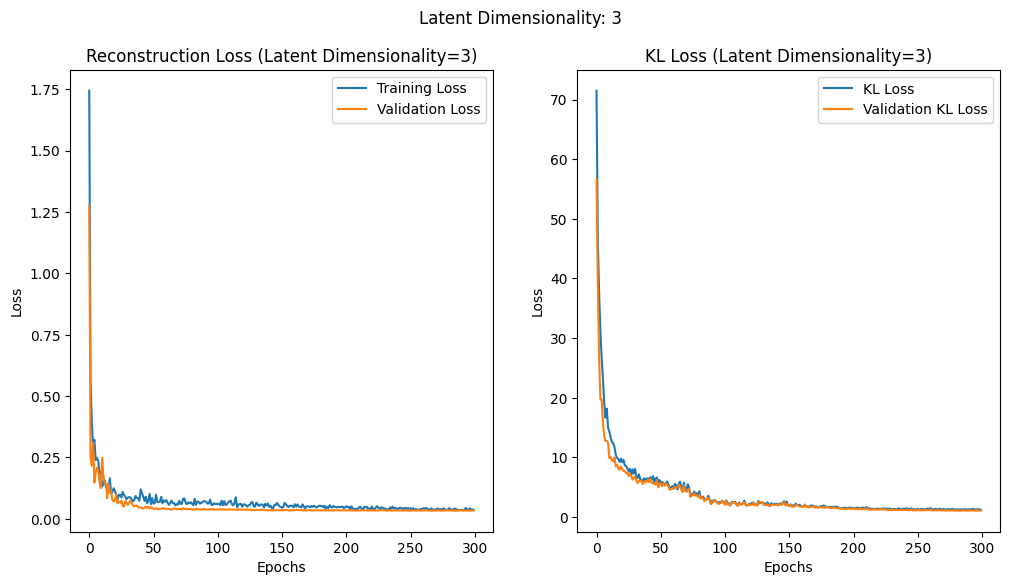

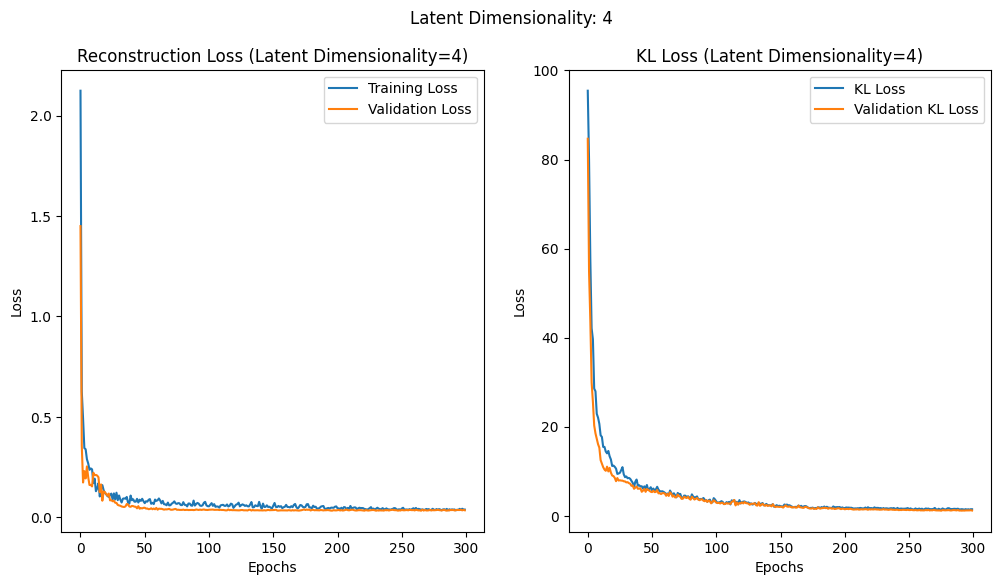

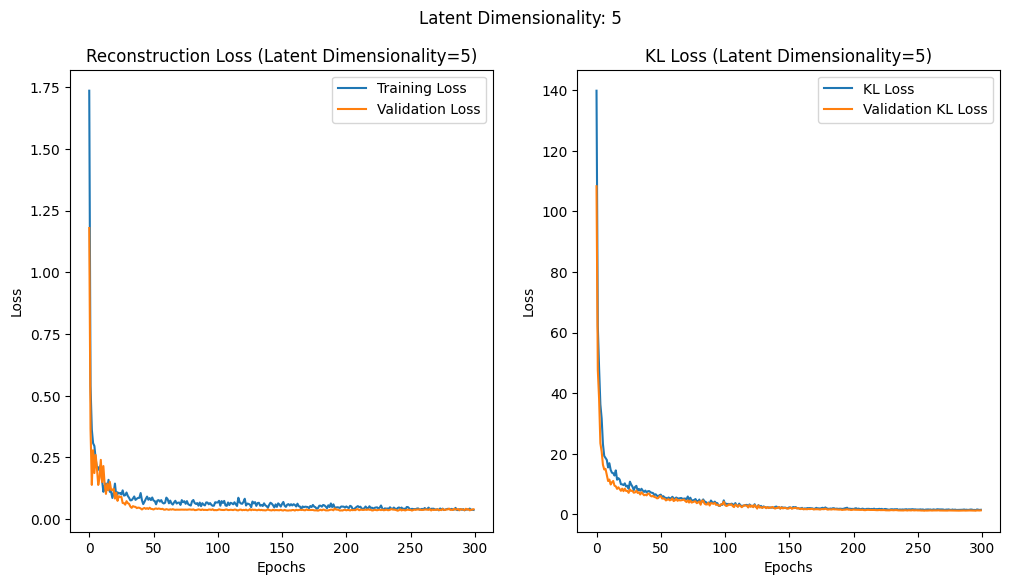

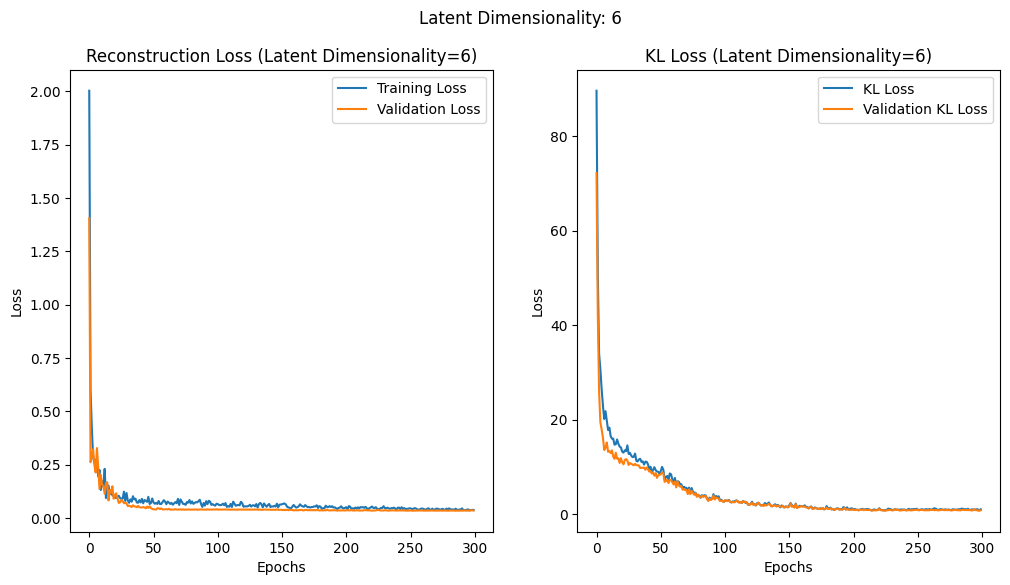

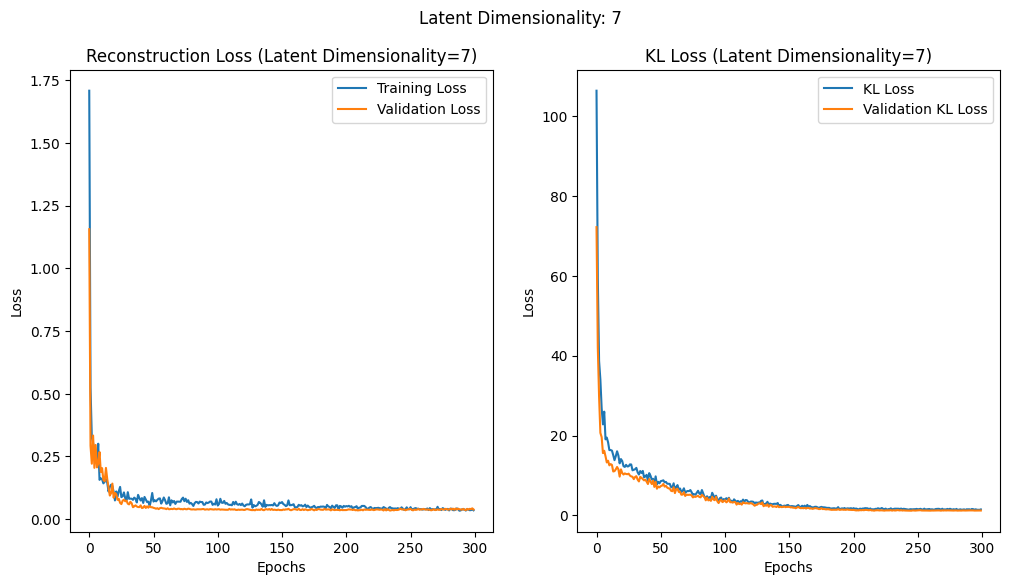

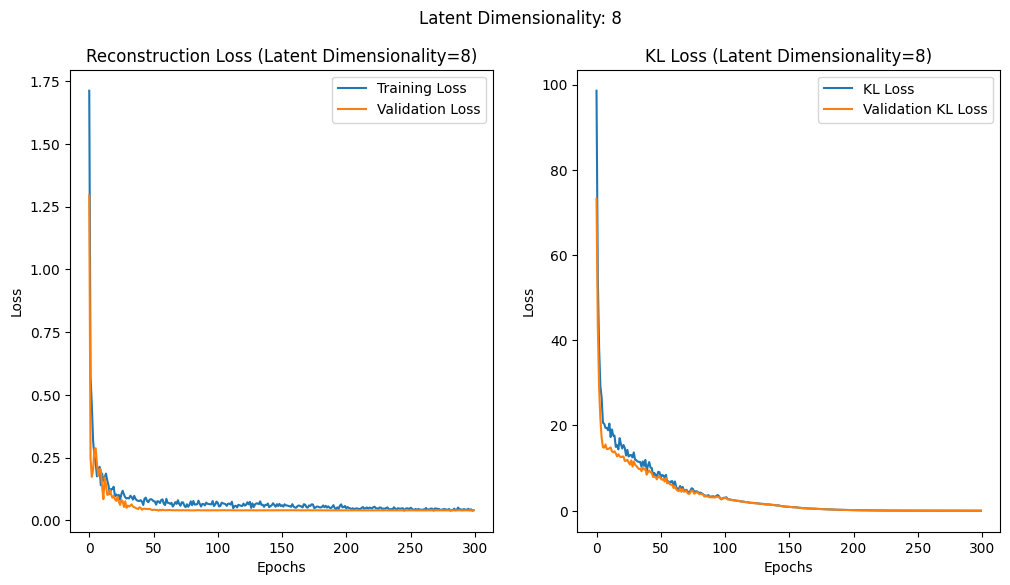

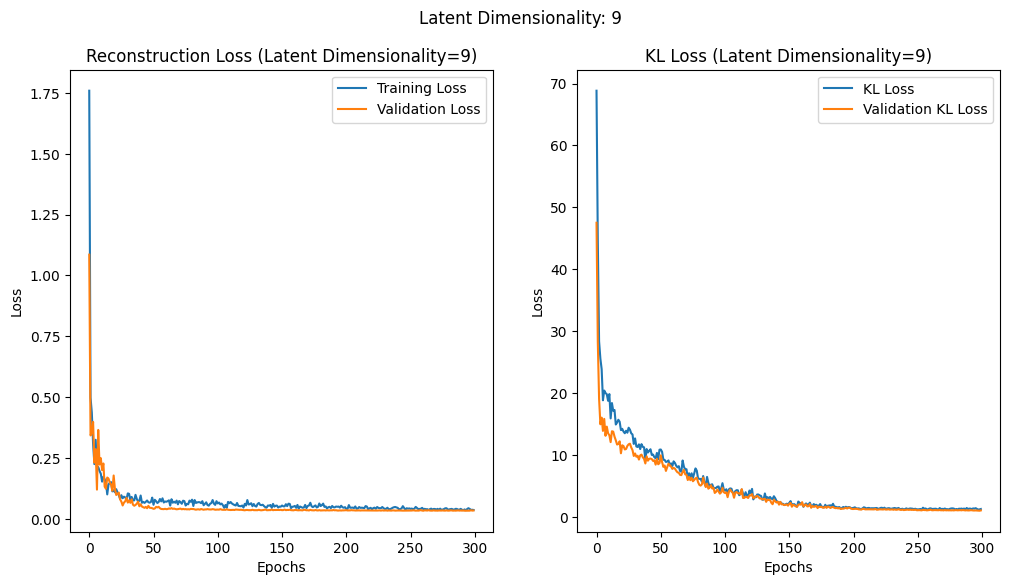

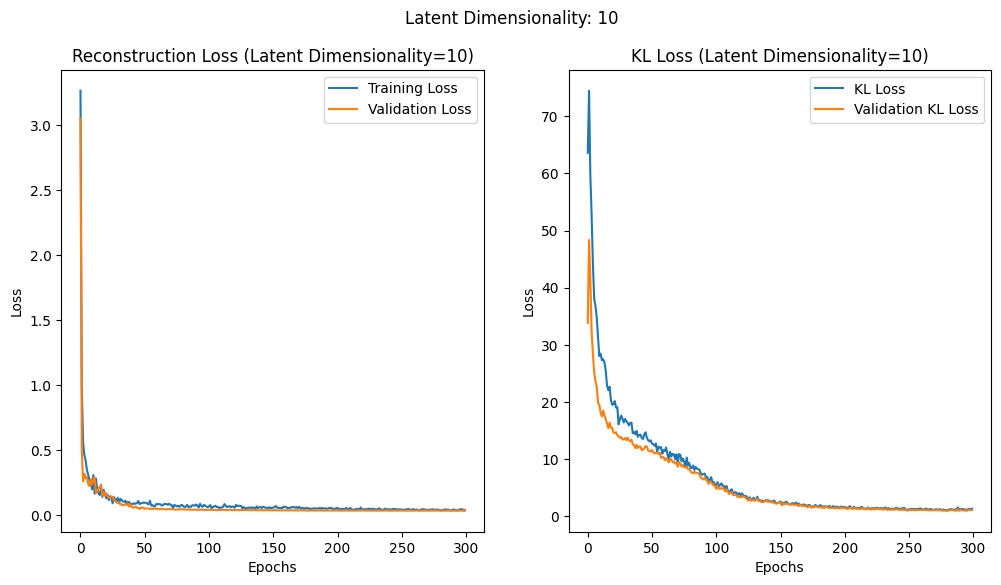

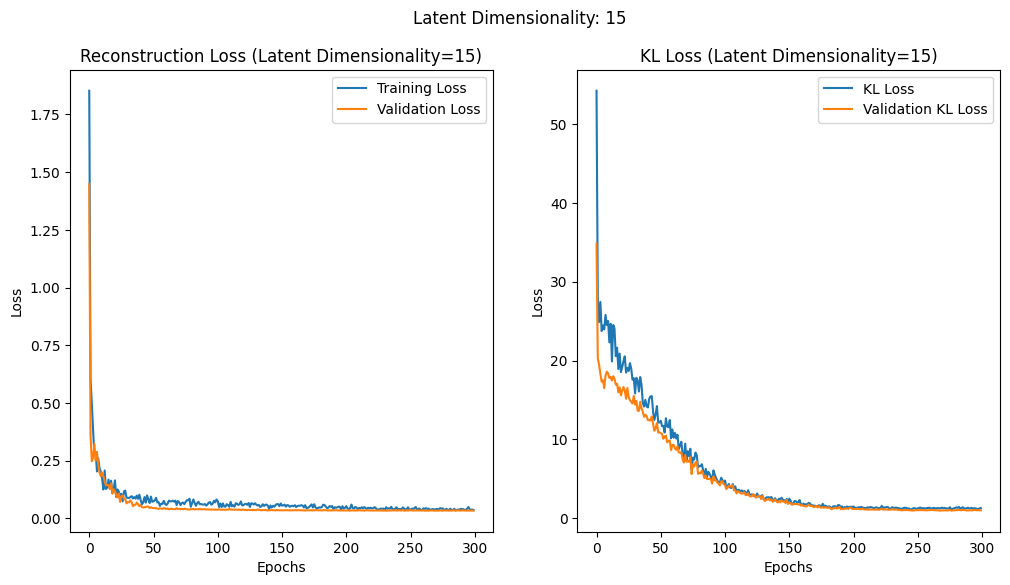

In [46]:
for i, history in enumerate(hist):
    l_dim = latent_dims[i]

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Reconstruction Loss
    ax1.plot(history.history['reconstruction_loss'], label='Training Loss')
    ax1.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
    ax1.set_title(f'Reconstruction Loss (Latent Dimensionality={l_dim})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot KL Loss
    ax2.plot(history.history['kl_loss'], label='KL Loss')
    ax2.plot(history.history['val_kl_loss'], label='Validation KL Loss')
    ax2.set_title(f'KL Loss (Latent Dimensionality={l_dim})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add a common title for the figure
    fig.suptitle(f'Latent Dimensionality: {l_dim}')

    # Display the figure
    plt.show()

In [47]:
latent_dims_str = [str(dim) for dim in latent_dims]
result_df = pd.DataFrame(val_results, columns=['kl_loss','r_squared', 'reconstruction_loss', 'total_loss'] ,index=latent_dims_str)

# Display results
print(result_df[['kl_loss', 'reconstruction_loss', 'total_loss', 'r_squared']])

     kl_loss  reconstruction_loss  total_loss  r_squared
2   0.809397             0.036998    0.846396   0.736927
3   1.075676             0.034020    1.109697   0.758103
4   1.176870             0.035183    1.212053   0.749831
5   1.308053             0.039977    1.348030   0.715748
6   0.827838             0.034683    0.862521   0.753387
7   1.223764             0.038304    1.262067   0.727645
8   0.001475             0.039505    0.040979   0.719105
9   1.047455             0.034444    1.081900   0.755086
10  1.064274             0.033582    1.097856   0.761222
15  0.989315             0.033937    1.023252   0.758696
